# Comparing numerical methods for exact marginal likelihood calculations 
I have 3 calculation methods that are inconsistent for low amounts of data and consistent for high amounts of data.

In summary, my function seems robust enough to work, but I can always check against these 2 other methods if I have strange results.


In [1]:
import numpy as np
from scipy import stats

import matplotlib.pylab as plt
%matplotlib inline

from time import time

import sys
sys.path.append('../')
from bayes_linear_regression import norm_inv_gamma as nig

from scipy.stats import invgamma

from time import time

In [2]:
from itertools import combinations

## A polynomial model with decoys
### The true polynomial is of order 3

In [3]:
def standardize(x):
    """
    Make each column of x have a mean equal to 0 and a standard deviation equal to 1.
    """
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def gen_poly_model(n, params, A, B, sigma2):
    x = np.linspace(-5,5, n).reshape((n, 1))
    x_stand = standardize(x)

    y = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=n).reshape((n, 1))
    for i, g in enumerate(params):
        y += g * x ** i 
    
    return x_stand, y

def polynomial_model_selection(params, A, B, powers, sample_post=True, data_sizes=(20, 40, 80, 160, 320), nsamps=1000):
    """
    Generate a polynomial model from 1 dimensional input and perform model selection using the marginal likelihood and
    the mean log of the likelihood, where the mean could be over the posterior or prior. Model selection is performed
    for different sized data sets.

    Parameters
    ----------
    params: list-like
        The multiplicative parameters of the true polynomial model. The length of the list determines the order of
        the polynomial. E.g. params = [a, b, c] implies y = a*x^0 + b*x^1 + c*x^2 + noise.
    powers: list-like
        The powers of x to explore in the models.
    A, B: int, int
        The inverse gamma parameters for the variance of the noise.
    sample_post: bool
        Whether to sample the model parameters from the posterior (True) or prior (False).
    data_sizes: list-like
        The size of the data set with which to perform model selection. It is expected that entries in data_sizes
        are in ascending order.
    nsamps: int
        The number of posterior or prior samples with which to estimate the mean likelihood.

    Returns
    -------
    margs: list of arrays
        The marginal likelihoods for each data set size and order of polynomial.
    likes: list of arrays
        The mean log likelihoods for each data set size and order of polynomial.
    likes_samps: list
        The samples of the log likelihoods for each data set size and order of polynomial.
    """
    # Using the mode of the inverse gamma distribution for the variance of the noise
    sigma2 = B / (A + 1)  # The mode of the inverse gamma

    # Generate polynomial data with random noise using the largest data set size
    x, y = gen_poly_model(data_sizes[-1], params, A, B, sigma2)

    t0 = time()
    likes = []
    likes_samps = []
    margs = []
    # Randomize the order in which the data appears
    inds = np.random.choice(len(x), size=len(x), replace=False)
    for n in data_sizes:
        # Subsample the data up to maximum data set size
        x_sub = x[inds[:n], 0].reshape((n, 1))
        y_sub = y[inds[:n]].reshape((n, 1))

        lnmarglike = []  # To store log marginal likelihood
        lnmeanlike = []  # To store the posterior mean of the log likelihood
        lnmeanlike_samps = []  # To store the posterior samples of the log likelihood

        explanatory = x_sub
        for p in powers:
            if p != 1:
                # Add a power to the explanatory variables
                explanatory = np.hstack((explanatory, x_sub ** p))
            # Standardize the explanatory variables
            stand_mat = (explanatory - np.mean(explanatory, axis=0)) / np.std(explanatory, axis=0)

            # Set up the prior and get the posterior
            cov = np.eye(explanatory.shape[1]) * 10
            mu = np.zeros(shape=(explanatory.shape[1], 1))
            prior = nig.NormalInverseGamma(a=A, b=B, mu=mu, cov=cov)
            post = nig.PostNormalInverseGamma(prior, stand_mat, y_sub)

            # Record the TRUE log marginal likelihood
            lnmarglike.append(post.log_marg_like)

            # Sample from the posterior and record mean log likelihood
            if sample_post:
                samps = nig.sample_loglike(post, stand_mat, y_sub, nsamps=nsamps)
            else:
                samps = nig.sample_loglike(prior, stand_mat, y_sub, nsamps=nsamps)
            lnmeanlike.append(np.mean(samps))
            lnmeanlike_samps.append(samps)

        likes.append(np.array(lnmeanlike))
        likes_samps.append(lnmeanlike_samps)
        margs.append(np.array(lnmarglike))
    print('Time taken in minutes =', (time() - t0) / 60)

    return margs, likes, likes_samps
def plot_polynomial_selection(margs, likes, likes_samps, data_sizes, powers, nboots=1000):
    """
    Plot the polynimial model selection experiment and compare the marginal likelihood (plot 1) with using the mean
    log likelihood (plot 2).
    """
    nsamps = len(likes_samps[0][0])
    nboots = 500

    # Bootstrap the posterior/prior likelihood samples for confidence intervals
    lower = []
    upper = []
    median = []
    for i in range(len(data_sizes)):
        exp_boots = np.zeros((nboots, len(powers)))
        for b in range(nboots):
            boot_samps = np.vstack([likes_samps[i][j][np.random.choice(nsamps, nsamps)] for j in range(len(powers))])
            boot_mean = boot_samps.mean(axis=1)
            shifted = boot_mean - np.max(boot_mean)
            exp_boots[b, :] = np.exp(shifted)
        lower.append(np.percentile(exp_boots, 2.5, axis=0))
        upper.append(np.percentile(exp_boots, 97.5, axis=0))
        median.append(np.percentile(exp_boots, 50.0, axis=0))

    trans = 0.1
    colz = ('C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7')

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    for i, n in enumerate(data_sizes):
        shifted = margs[i] - np.max(margs[i])
        ax[0].plot(powers, np.exp(shifted), label='n = {0}'.format(n), lw=3, ls='-')
        ax[0].legend()

        shifted = likes[i] - np.max(likes[i])
        ax[1].fill_between(powers, lower[i], upper[i], color=colz[i], alpha=trans)
        ax[1].plot(powers, np.exp(shifted), label='n = {0}'.format(n), lw=3, color=colz[i])
        ax[1].legend()

    return fig, ax


def old_gen_poly_model(n, a, b, c, A, B, sigma2):
    #sigma2 = invgamma.rvs(A, loc=0, scale=B, size=1) 
    noise = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=n)
    noise = np.reshape(noise, (n, 1))

    mu = n
    #X = np.random.normal(loc=0, scale=1.5, size=n).reshape((n, 1))
    X = np.linspace(-5,5, n).reshape((n, 1))
    X_stand = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    Y = a * X + b * X**2 + c * X**3 + noise
    
    return X, Y

y = 0x^0 + 1x^1 + 2x^2 + -0.3x^3 


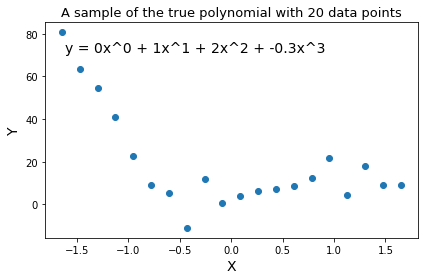

In [14]:
# The polynomial parameters
#params = [0, 1, 2, -0.3, 0.1] # 0th, 1st, 2nd, 3rp power etc...
params = [0, 1, 2, -0.3]
#params = [0, 1, 5, -1]
# The inverse gamma parameters
A = 1
B = 100

sigma2 = B / (A + 1) # The mode of the inverse gamma
#data_sizes = (20, 40, 80, 160, 320)
data_sizes = (10, 20, 40, 80, 160)
powers = (1, 2, 3, 4, 5, 6, 7)
nsamps = 1000

n = 20
x_stand, y = gen_poly_model(n, params, A, B, sigma2)
plt.scatter(x_stand, y)
plt.title('A sample of the true polynomial with {0} data points'.format(n), fontsize=13)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)

ymin = y.min()
ymax = y.max()
yr = ymax - ymin

xmin = x_stand.min()
xmax = x_stand.max()
xr = xmax - xmin

s = 'y ='
for i, p, in enumerate(params):
    s += ' {0}x^{1} +'.format(p, i)
s = s[:len(s)-1]
print(s)

plt.text(xmin + 0.01*xr, ymin + 0.9*yr, s=s, fontsize=14)
plt.tight_layout()
plt.show()

### Posterior sampling of log likelihood

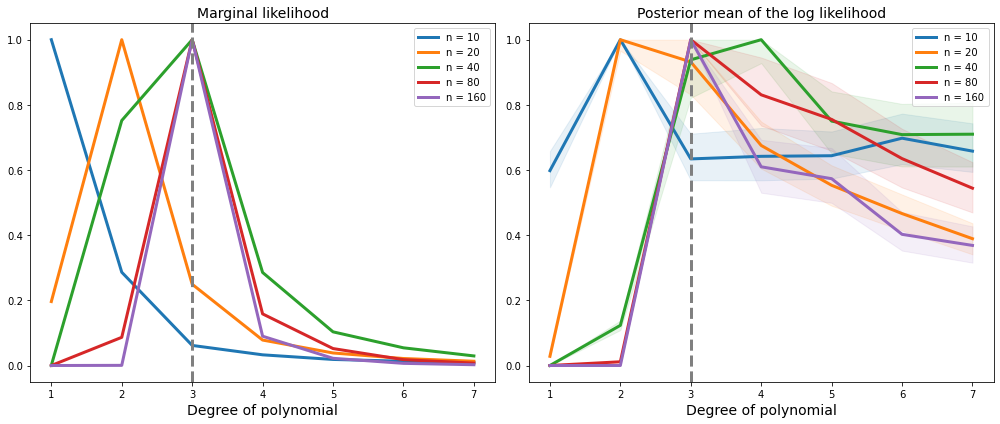

In [7]:
margs, likes, likes_samps = polynomial_model_selection(params, A, B, powers, True, data_sizes, nsamps)
fig, axis = plot_polynomial_selection(margs, likes, likes_samps, data_sizes, powers, nboots=1000)

axis[0].set_title('Marginal likelihood', fontsize=14)
axis[1].set_title('Exponential of the posterior mean of the log likelihood', fontsize=14)

for ax in axis:
    ax.set_xlabel('Degree of polynomial', fontsize=14)
    ax.axvline(len(params) -1 , label='True degree', ls='--', lw=3, color='grey')
plt.tight_layout()
plt.show()

### Prior sampling of the log likelihood

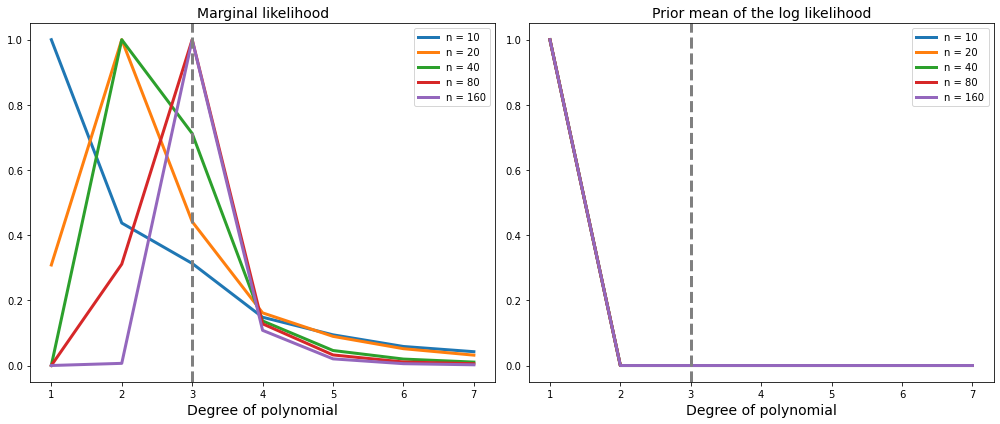

In [10]:
margs, likes, likes_samps = polynomial_model_selection(params, A, B, powers, False, data_sizes, nsamps)
fig, axis = plot_polynomial_selection(margs, likes, likes_samps, data_sizes, powers, nboots=1000)

axis[0].set_title('Marginal likelihood', fontsize=14)
axis[1].set_title('Exponential of the prior mean of the log likelihood', fontsize=14)

for ax in axis:
    ax.set_xlabel('Degree of polynomial', fontsize=14)
    ax.axvline(len(params) -1 , label='True degree', ls='--', lw=3, color='grey')
    
plt.tight_layout()
plt.show()